# Tutorial 1 - Intro to NNs

In this tutorial, you will learn the basics of NNs

In [60]:
# NN packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# Optimizers
import torch.optim as optim

# Loading data
from torch.utils.data import TensorDataset, DataLoader

# Other packages for plotting and data maipulation
import matplotlib.pyplot as plt
import numpy as np

In [61]:
# Set random seed for reproducibility
torch.manual_seed(17)

# Detect CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## 1. First we simply look at taking derivatives; no NN yet

In [62]:
def f(x):
    return x**2

x = torch.tensor(2, dtype=torch.float32, device=device)
x, f(x)

(tensor(2.), tensor(4.))

In [63]:
# Taking derivatives is very easy, since torch tensors implement a gradient function. 
# We just need to tell torch that we want to keep track of gradients
x.requires_grad = True

# compute f(x); calling backward on f(x) calculates the gradients of x by back-propagation of x through f
y = f(x)
y.backward()
print(x.grad)

tensor(4.)


In [64]:
# continuing calling y.backward() will continue to accumulate gradients in x, 
# so we need to make sure we zero gradients before calling it again
y = f(x)
y.backward()
print(x.grad)
y = f(x)
y.backward()
print(x.grad)
y = f(x)
y.backward()
print(x.grad)

# zero the gradient
x.grad.data.zero_()
y = f(x)
y.backward()
print(x.grad)

tensor(8.)
tensor(12.)
tensor(16.)
tensor(4.)


In [65]:
# we can also take higher derivatives, but we need to tell torch that we want to do this. 
# Otherwise it does not store the first derivative computation to save memory:
x.grad.data.zero_()
y = f(x)
y.backward()
df_dx = x.grad
print(df_dx)
try:
    d2f_dx2 = torch.autograd.grad(df_dx, x)
    print(d2f_dx2)
except RuntimeError as e:
    print(e)

tensor(4.)
element 0 of tensors does not require grad and does not have a grad_fn


In [66]:
# The way to do this is to call backward with the retain_graph=True argument
x.grad.data.zero_()
y = f(x)
dy_dx = torch.autograd.grad(y, x, create_graph=True)[0]
print("First derivativ:", dy_dx)

# Second derivative: d²y/dx²
d2y_dx2 = torch.autograd.grad(dy_dx, x)[0]
print("Second derivative:", d2y_dx2)

First derivativ: tensor(4., grad_fn=<MulBackward0>)
Second derivative: tensor(2.)


tensor([-2.0000, -1.9900, -1.9800, -1.9700, -1.9600], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([-0.0344, -0.0073, -0.0002,  0.0004,  0.0088], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


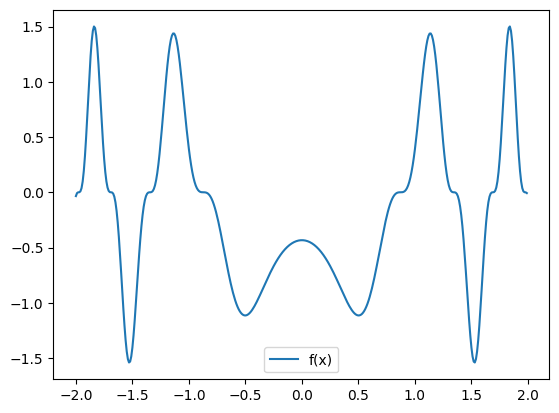

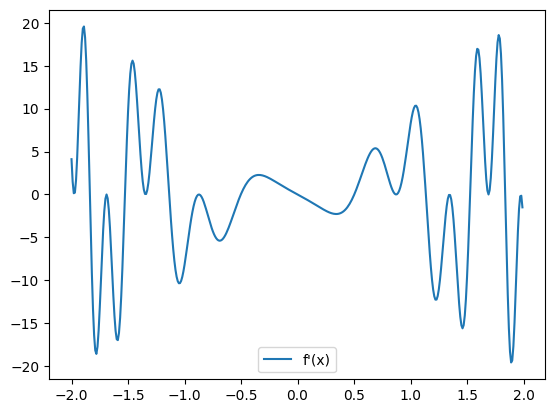

In [67]:
# let us now illustrate how powerful this is by taking derivatives of a more complicated function
def f(x):
    return torch.sin(3 * x**2 + 4)**3 * torch.cosh(torch.sin(x))

# torch automatically threads over the batch dimension, i.e., the 1st entry in an array
xs = torch.tensor(np.arange(-2, 2, .01), requires_grad=True, device=device)
ys = f(xs)
print(xs[:5])
print(ys[:5])

# for plt to be able to plot, the data needs to be on the CPU, and we need to remove keeping track of gradients
plt.plot(xs.cpu().detach().numpy(), ys.cpu().detach().numpy(), label="f(x)")
plt.legend()
plt.show()

# since I now have a sequence of scalars, the derivatives will be a vector, and I have to tell torch what it should look like
dys_dxs = torch.autograd.grad(ys, xs, grad_outputs=torch.ones_like(xs))[0]

plt.plot(xs.cpu().detach().numpy(), dys_dxs.cpu().detach().numpy(), label="f'(x)")
plt.legend()
plt.show()

## 2. Our first NN - Creating Data

Since we need to take derivatives all the time, torch wraps the code we wrote above in optimizers like sgd in the torch.optim package. This also implements other optimizers such as adam, which have more bells and whistles attached than vanilla sgd.

We will play with a simple function
$$f(x, y) = \left\{\begin{array}{ll}+1& \text{if } x*y \geq 0\\-1& \text{else}\end{array}\right.$$

In [68]:
# First we need to generate some data. We generate 10k (x,y) pairs
xs, ys = np.arange(-2, 2, .04), np.arange(-2, 2, .04)

x_vecs = [[x, y] for x in xs for y in ys]

def f(x_vec):
    x, y = x_vec
    return (-1) ** (x*y < 0)

labels = [f(x_vec) for x_vec in x_vecs]

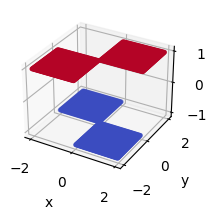

In [69]:
def plot_function(xs, labels):
    xx = np.array(xs)[:, 0]
    yy = np.array(xs)[:, 1]
    zz = np.array(labels)
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(xx, yy, zz, c=labels, cmap='coolwarm', s=5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')
    plt.tight_layout()
    plt.show()

plot_function(x_vecs, labels)

## 3. Our first NN - Setting up train and test sets

In [70]:
xs, ys = torch.tensor(x_vecs, dtype=torch.float32, device=device), torch.tensor(labels, dtype=torch.float32, device=device)

# randomly scramble xs and ys, but make sure that the labels keep aligned with the corresponding features
rand_scramble = np.random.permutation(len(xs))
xs, ys = xs[rand_scramble], ys[rand_scramble]

# perform train-test split 90:10
x_train, x_test = xs[:int(.9 * len(xs))], xs[int(.9 * len(xs)):]
y_train, y_test = ys[:int(.9 * len(xs))], ys[int(.9 * len(xs)):]
print(f"Train Features: {x_train.shape}, Train Labels: {y_train.shape}")
print(f"Test  Features: {x_test.shape}, Test  Labels: {y_test.shape}")

# we can put these into a data loader that provides batches of (x,y) pairs of the specified size
# to keep the (x,y)-paris together we first create a tensor dataset
# also, torch wants the output to be 1D vectors rather than scalars, so we need to change [y0, y1, ...] to [[y0], [y1], ...]
# we can do this with unsqueeze()
tensor_train, tensor_test = TensorDataset(x_train, y_train.unsqueeze(-1)), TensorDataset(x_test, y_test.unsqueeze(-1))
train_loader, test_loader = DataLoader(tensor_train, batch_size=64, shuffle=True), DataLoader(tensor_test, batch_size=1000, shuffle=False)

Train Features: torch.Size([9000, 2]), Train Labels: torch.Size([9000])
Test  Features: torch.Size([1000, 2]), Test  Labels: torch.Size([1000])


## 4. Our first NN - Setting up the MLP

In [71]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # 2D input, 3D hidden
        self.fc2 = nn.Linear(3, 1)  # 3D hidden, 1D output
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)  # ReLU activation, can also try F.sigmoid, F.tanh, ...
        x = self.fc2(x)
        return x

Summary of the NN architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
            Linear-2                    [-1, 1]               4
Total params: 13
Trainable params: 13
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------

Example Output:
f(0.8400, -0.1200) = -0.3840
Plot of untrained NN:


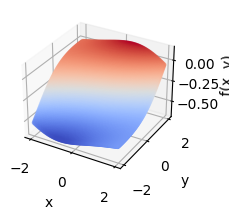

In [72]:
# Instantiate the model
model = SimpleMLP().to(device)

# optional but recommended: look at the model
import torchsummary
print("Summary of the NN architecture:")
torchsummary.summary(model, input_size=x_train.shape[1:])

# now we can apply it to our train data. since it is not trained, the output will be random (as the weights and biases were initialized ranodmly)
y_hats = model(xs)
print("\nExample Output:")
print(f"f({xs[0,0].item():.4f}, {xs[0,1].item():.4f}) = {y_hats[0].item():.4f}")

# you might want to play around with the activation function to see how this changes...
# also note that each time you run this cell, the model is reinitialized randomly, so the output changes every time
print("Plot of untrained NN:")
plot_function(xs.cpu().detach().numpy(), y_hats.cpu().detach().numpy().squeeze())

## 5. Our first NN - Training

In [73]:
# We train the model with MSE Loss and use stochastic gradient descend
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

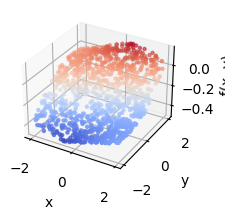

Epoch  1: Train loss: 1.0911, Test loss: 1.0486


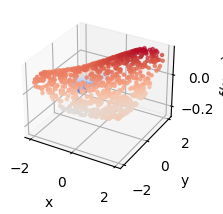

Epoch 11: Train loss: 0.9245, Test loss: 0.9221


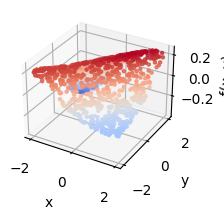

Epoch 21: Train loss: 0.8232, Test loss: 0.8208


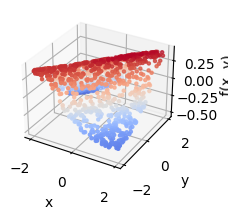

Epoch 31: Train loss: 0.7002, Test loss: 0.6998


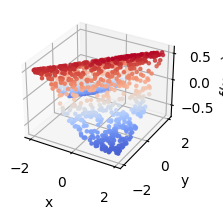

Epoch 41: Train loss: 0.5960, Test loss: 0.6008


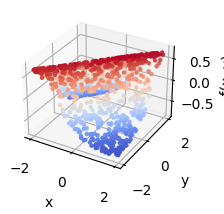

Epoch 51: Train loss: 0.5289, Test loss: 0.5395


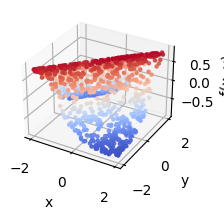

Epoch 61: Train loss: 0.4931, Test loss: 0.5080


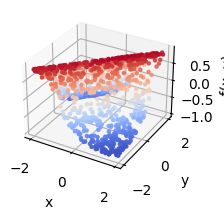

Epoch 71: Train loss: 0.4758, Test loss: 0.4937


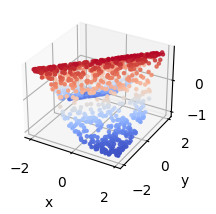

Epoch 81: Train loss: 0.4677, Test loss: 0.4876


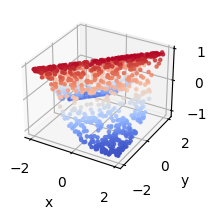

Epoch 91: Train loss: 0.4638, Test loss: 0.4853


In [74]:
# a simple train loop that keeps track of the accuracies. We also plot the NN output every 10 epochs
def train_model(model, train_loader, test_loader, epochs=100, plot_interval=10):
    # To track training progress
    training_history = {
        'train_loss': [],
        'test_loss': []
    }
    
    for epoch in range(epochs):
        model.train()  # set into training mode, activates dropouts for example.
        epoch_train_loss = 0
        
        # Training loop
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Track train loss
            epoch_train_loss += loss.item()
        
        epoch_train_loss /= len(train_loader)
        training_history['train_loss'].append(epoch_train_loss)
        
        # Evaluate on test set
        model.eval()  # set into eval mode, deactivates dropouts for example.
        epoch_test_loss = 0
        xs_test, ys_test = [], []
        for i, (inputs, labels) in enumerate(test_loader):
            # no backward pass or optimization step for test!
            xs_test.append(inputs.cpu().detach())
            with torch.no_grad():
                outputs = model(inputs)
                ys_test.append(outputs.cpu().detach())
                loss = criterion(outputs, labels)
                epoch_test_loss += loss.item()
        
        epoch_test_loss /= len(test_loader)
        
        # combine batches into one torch tensor
        xs_test = torch.cat(xs_test, dim=0)
        ys_test = torch.cat(ys_test, dim=0).squeeze()
        training_history['test_loss'].append(epoch_test_loss)
        
        if epoch % plot_interval == 0:
            plot_function(xs_test, ys_test)
            print(f"Epoch {epoch+1:2d}: Train loss: {epoch_train_loss:.4f}, Test loss: {epoch_test_loss:.4f}")
        
    
    return model, training_history

model, hist = train_model(model, train_loader, test_loader, epochs=100, plot_interval=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             192
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 1]              65
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


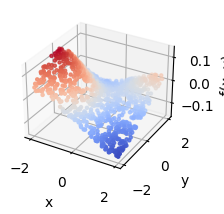

Epoch  1: Train loss: 0.9840, Test loss: 0.9502


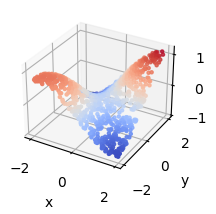

Epoch 11: Train loss: 0.4371, Test loss: 0.4140


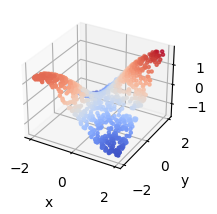

Epoch 21: Train loss: 0.3010, Test loss: 0.2942


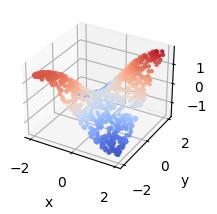

Epoch 31: Train loss: 0.2909, Test loss: 0.2865


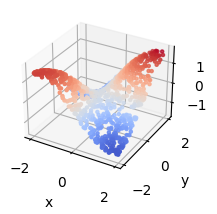

Epoch 41: Train loss: 0.2851, Test loss: 0.2826


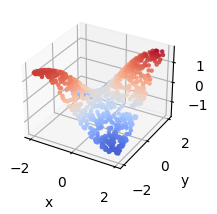

Epoch 51: Train loss: 0.2804, Test loss: 0.2772


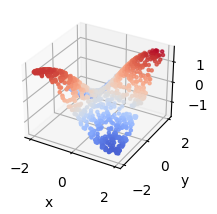

Epoch 61: Train loss: 0.2759, Test loss: 0.2734


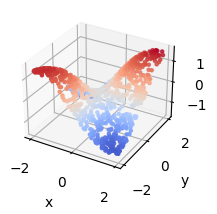

Epoch 71: Train loss: 0.2714, Test loss: 0.2697


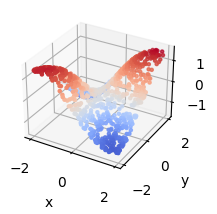

Epoch 81: Train loss: 0.2673, Test loss: 0.2655


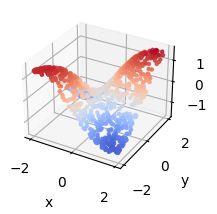

Epoch 91: Train loss: 0.2631, Test loss: 0.2609


In [75]:
# let's make the NN more powerful
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)   #  2D input,  64D hidden
        self.fc2 = nn.Linear(64, 64)  # 64D hidden, 64D hidden
        self.fc3 = nn.Linear(64, 1)   # 64D hidden,  1D output
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)  # ReLU activation, can also try F.sigmoid, F.tanh, ...
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        return x

model = SimpleMLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
torchsummary.summary(model, input_size=x_train.shape[1:])

model, hist = train_model(model, train_loader, test_loader, epochs=100, plot_interval=10)

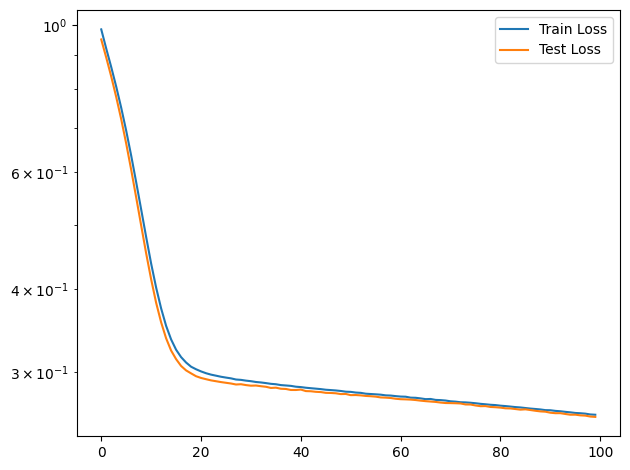

In [76]:
plt.plot(hist['train_loss'], label="Train Loss")
plt.plot(hist['test_loss'], label="Test Loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

# Now it's your turn

I list some suggestions of what you could do below. Pick the one (or ones) that intrest you the most, or just play with the notebook and investigate your own questions.

## Exercise 1: Extremization

In [57]:
# The volume of an ball in $d$ dimensions is given by
def vol_B(d, r=1):
    return torch.pi**(d/2) / torch.exp(torch.lgamma(d/2 + 1)) * r**d

print([vol_B(torch.tensor(d), 1).item() for d in range(8)])

# Use gradient ascend find the (fractional) dimension with the maximal volume of the unit d-ball
alpha = 1e-1
d = torch.tensor(1.1, dtype=torch.float32, requires_grad=True)
res, dv_dd = [], []
for e in range(200):
    y = vol_B(d, r=1)
    y.backward()
    # Gradient ascent step
    with torch.no_grad():
        df_dd = d.grad
        d += alpha * df_dd

    dv_dd.append(df_dd.clone().cpu().detach().numpy())
    res.append(d.clone().cpu().detach().numpy())
    if e % 10 == 0:
        print(f"Dimension: {d:.2f}, Gradient: {df_dd:.2f}")

    # Manually zero the gradient for the next iteration
    d.grad.zero_()

print(d.item())

[1.0, 2.000000238418579, 3.1415927410125732, 4.188790798187256, 4.934802532196045, 5.263789176940918, 5.167713165283203, 4.724766254425049]
Dimension: 1.21, Gradient: 1.12
Dimension: 2.35, Gradient: 1.10
Dimension: 3.32, Gradient: 0.85
Dimension: 4.01, Gradient: 0.57
Dimension: 4.46, Gradient: 0.36
Dimension: 4.74, Gradient: 0.23
Dimension: 4.93, Gradient: 0.15
Dimension: 5.04, Gradient: 0.09
Dimension: 5.12, Gradient: 0.06
Dimension: 5.17, Gradient: 0.04
Dimension: 5.20, Gradient: 0.03
Dimension: 5.22, Gradient: 0.02
Dimension: 5.23, Gradient: 0.01
Dimension: 5.24, Gradient: 0.01
Dimension: 5.25, Gradient: 0.00
Dimension: 5.25, Gradient: 0.00
Dimension: 5.25, Gradient: 0.00
Dimension: 5.25, Gradient: 0.00
Dimension: 5.26, Gradient: 0.00
Dimension: 5.26, Gradient: 0.00
5.256098747253418


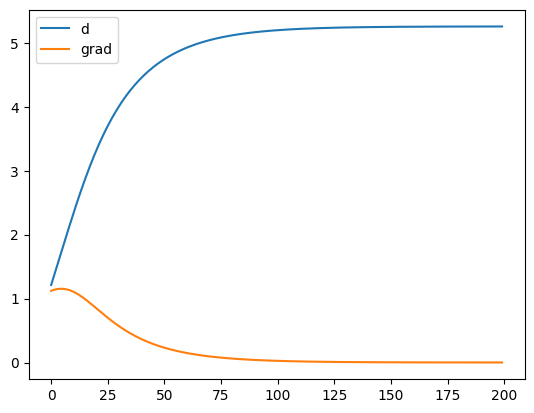

In [58]:
plt.plot(res, label="d")
plt.plot(dv_dd, label="grad")
plt.legend();

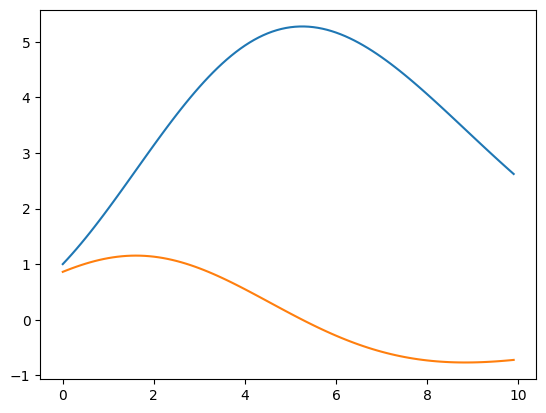

In [48]:
derivs = []
for dd in np.arange(0,10,.1):
    d = torch.tensor(dd, requires_grad=True)
    y = vol_B(d, r=1)
    y.backward()
    df_dd = d.grad
    derivs.append(df_dd.cpu().detach().numpy())

plt.plot(np.arange(0,10,.1), [vol_B(torch.tensor(d), 1).item() for d in np.arange(0,10,.1)])
plt.plot(np.arange(0,10,.1), derivs)

## Exercise 2: NN hyperparameters

In [ ]:
# Play with the NN hyperparameters (width, depth, activation function, optimizer, learning rate,...)

## Exercise 3: Learning a function

In [ ]:
# Write a NN that interpolates the function
def f(x_vec):
    x, y = x_vec
    return torch.math.cos(x) * torch.math.sin(y)